
# Benchmarking antimicrobial peptides


In [54]:
# !pip install "seqme[hyformer]==0.3.6" "hyformer @ git+https://github.com/szczurek-lab/hyformer.git@v2.0"

In this notebook, we use seqme to evaluate antimicrobial peptide sequences.


In [55]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import torch

import seqme as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data


Let's load the datasets.


In [57]:
BASE_PATH = Path("./")

BENCHMARK_PATH = "dataframe.pkl"

DATASET_PATHS = {
    "UniProt": BASE_PATH / "data" / "uniprot_8_50_100.fasta",
    "DBAASP": BASE_PATH / "data" / "dbaasp.fasta",
    # Models
    "AMP-Diffusion": BASE_PATH / "data" / "amp-diffusion.fasta",
    "AMP-GAN": BASE_PATH / "data" / "amp-gan.fasta",
    "HydrAMP": BASE_PATH / "data" / "hydramp.fasta",
    "MMCD": BASE_PATH / "data" / "MMCD.fasta",
    "PepCVAE": BASE_PATH / "data" / "pepcvae.fasta",
}

In [58]:
datasets = {name: sm.read_fasta(path) for name, path in DATASET_PATHS.items()}

In [59]:
AMINO_ACID_LETTERS = list("ACDEFGHIKLMNPQRSTVWY")
AMINO_ACID_SET = set(AMINO_ACID_LETTERS)


def verify(sequence: str):
    invalid = set(sequence) - AMINO_ACID_SET
    if invalid:
        raise ValueError(f"Invalid amino acid(s): {', '.join(sorted(invalid))}")


for model_name, sequences in datasets.items():
    print(f"Parsing '{model_name}', n={len(sequences)}")
    datasets[model_name] = [sequence for sequence in sequences if set(sequence) <= AMINO_ACID_SET]

Parsing 'UniProt', n=2933310
Parsing 'DBAASP', n=8967
Parsing 'AMP-Diffusion', n=47671
Parsing 'AMP-GAN', n=150000
Parsing 'HydrAMP', n=50000
Parsing 'MMCD', n=18890
Parsing 'PepCVAE', n=50000


Let's setup the data and models.


In [60]:
sources = list(DATASET_PATHS.keys())

n_samples = 10_000
seed = 42

benchmark_datasets = {
    source: sm.utils.subsample(datasets[source], n_samples=n_samples, seed=seed)
    if len(datasets[source]) > n_samples
    else datasets[source]
    for source in sources
}

seqs_uniprot = benchmark_datasets["UniProt"]
seqs_amps = benchmark_datasets["DBAASP"]

## Models


Let's load the models and set up the cache.


In [61]:
CACHE_PATH = None # "new_cache.pkl"

init_cache = sm.read_pickle(CACHE_PATH) if CACHE_PATH else None

Let's setup the third-party models.


Let's setup AMPlify.


In [62]:
# !conda create -n amplify_env python=3.9 -y

In [63]:
amplify = sm.models.ThirdPartyModel(
    entry_point="predict:predict",
    repo_path="./plugins/thirdparty/amplify",
    # python_bin="/opt/anaconda3/envs/amplify_env/bin/python",
    python_bin="/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/amplify_env/bin/python",
    repo_url="https://github.com/szczurek-lab/seqme-thirdparty",
    branch="amplify",
)

Let's setup amPEPpy.


In [64]:
# !conda create -n ampeppy_env python=3.8 -y

In [65]:
ampeppy = sm.models.ThirdPartyModel(
    entry_point="amPEPpy.predict:predict",
    repo_path="./plugins/thirdparty/ampep",
    # python_bin="/opt/anaconda3/envs/ampep_env/bin/python",
    python_bin="/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/ampeppy_env/bin/python",
    repo_url="https://github.com/szczurek-lab/seqme-thirdparty",
    branch="ampeppy",
)

Let's setup the cache.


In [ ]:
hyformer = sm.models.Hyformer(
    model_name=sm.models.HyformerCheckpoint.peptides_34M,
    batch_size=512,
    device=device,
    verbose=False,
)

cache = sm.Cache(
    models={
        "hyformer": hyformer,
        "amphiphilicity": sm.models.HydrophobicMoment(),
        "amPEPpy": ampeppy,
        "AMPlify": amplify,
    },
    init_cache=init_cache,
)

Model weights loaded from SzczurekLab/hyformer_peptides_34M
Model state_dict loaded with `strict=False`. Missing keys: [], Unexpected keys: ['prediction_head.dense.weight', 'prediction_head.dense.bias', 'prediction_head.out_proj.weight', 'prediction_head.out_proj.bias']


## Metrics


Let's select the metrics.


In [67]:
embedder = "hyformer"

metrics = [
    # sm.metrics.Count(),
    # sm.metrics.Uniqueness(),
    # sm.metrics.Length(),
    sm.metrics.Diversity(k=200, name="Diversity"),
    # sm.metrics.Novelty(reference=seqs_amps),
    sm.metrics.FKEA(embedder=cache.model(embedder), bandwidth=1.0, strict=False),
    sm.metrics.FBD(
        reference=seqs_uniprot, embedder=cache.model(embedder), name="FBD (UniProt)"
    ),
    sm.metrics.FBD(
        reference=seqs_amps, embedder=cache.model(embedder), name="FBD (DBAASP)"
    ),
    sm.metrics.ID(
        predictor=cache.model("AMPlify"), name="AMPlify", objective="maximize"
    ),
    sm.metrics.ID(
        predictor=cache.model("amPEPpy"), name="amPEPpy", objective="maximize"
    ),
]

metrics = [sm.metrics.Fold(metric, n_splits=5, strict=False) for metric in metrics]

`Fold` computes the metrics multiple using different folds, and aggregate the values (mean and standard deviation).

## Table


Let's compute the metrics for each group of sequences.


In [68]:
df = sm.evaluate(benchmark_datasets, metrics)

100%|██████████| 42/42 [26:59<00:00, 38.57s/it, data=PepCVAE, metric=amPEPpy]            


In [69]:
sm.to_pickle(df, BENCHMARK_PATH)

In [70]:
OUT_CACHE_PATH = "new_cache.pkl"
sm.to_pickle(cache.get(), OUT_CACHE_PATH)

In [71]:
df = sm.read_pickle(BENCHMARK_PATH)

In [72]:
metrics = ["Diversity", "FKEA", "FBD (DBAASP)", "FBD (UniProt)", "amPEPpy", "AMPlify"]
models = ["AMP-Diffusion", "AMP-GAN", "HydrAMP", "MMCD", "PepCVAE"]

df = df.loc[models]
df = df[metrics]

In [73]:
df = sm.rank(df, metrics=["AMPlify", "FBD (DBAASP)"])

Let's look at the results.


In [74]:
n_decimals = [2, 0, 0, 0, 2, 2, 0]
sm.show(df, color_style="bar", n_decimals=n_decimals)

,Diversity↑,FKEA↑,FBD (DBAASP)↓,FBD (UniProt)↓,amPEPpy↑,AMPlify↑,Rank↓
AMP-Diffusion,0.82±0.01,1251±16,62±1,262±3,0.36±0.01,0.15±0.01,1
AMP-GAN,0.81±0.01,1344±1,83±1,485±2,0.48±0.01,0.49±0.01,1
HydrAMP,0.86±0.01,1344±1,167±1,602±1,0.52±0.01,0.58±0.01,1
MMCD,0.81±0.01,1344±1,71±1,412±4,0.52±0.01,0.49±0.01,1
PepCVAE,0.87±0.01,1344±1,169±1,678±1,0.53±0.01,0.47±0.01,2


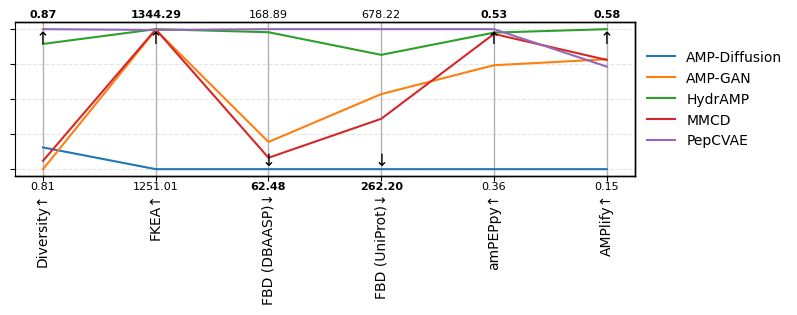

In [75]:
fig, ax = plt.subplots(figsize=(8,2))
sm.plot_parallel(df[metrics], arrow_size=12, ax=ax)
fig.savefig("./parallel.png", bbox_inches='tight', dpi=300)

In [ ]:
sm.to_latex(
    df,
    "./table.tex",
    n_decimals=n_decimals,
    caption="Best values are shown in \\textbf{bold}, and second best values are \\underline{underlined}. Table is generated using \\texttt{seqme}.",
)